# __Scenario A:__<br>Chymotrypsin inhibiton by a designed albumin fusion protein

Data provided by Marwa Mohamed (Institute of Cell Biology and Immunology, University of Stuttgart, Stuttgart, Germany)

Assessment of the inhibitory properties of an designed albumin as a chymotrypsin inhibitor

# Project background
In this scenaro, the inhibitory effect of a human serum albumin mutant on chymotrypsin was investigated. Thereby, the inhibition constant $K_{i}$ of the HSA wild-type was compared to HSA(M3) mutant. Both HSAs were fusionized into fusion proteins individually through a huFc.  
Experimental data from the HSA(wt)-huFc and HSA(M3)-huFc originate from two independent experiments. In each experiment the initial substrate concentration was varied. Once with the respective inhibitor, and once without. Therefore, $K_{i}$ and $K_{m}$ were determined indenpendently from each other. Additionally, each individual reaction condition was prepared in duplicates to ensure repeatability.  
Since 

## Experimental design

In order to assess the effect of the introduced mutations to the HSA(M3) variant, $K_{i}$ of the HSA wild-type was compared to HSA(M3) variant. Therefore, two indevidual experiments were conducted, estimating $K_{i}$ for each experiment individually. Each experiment consisted of enzyme reactions with initial substrate concentrations in the range of 0.25 - 2 mM, with and without the respective HSA.

## Data preparation

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyenzyme as pe
import copy
from EnzymePynetics.tools.parameterestimator import ParameterEstimator
from CaliPytion.tools.standardcurve import StandardCurve

import warnings
warnings.filterwarnings('ignore')

### Conversion of absortion signal to concentration

In order to convert the time-course absorption signal into concenrtation, a standard of p-NA was applied in the range of 0 - 0.3 mM in duplicates. The measured absorbance values were stored as an excel-file. In the following cell, a CaliPytion ```StandardCurve``` is generated directly from the excel-data.

Calibration data was automatically blanked.


,AIC
Quadratic,-161
3rd polynominal,-161
Linear,-143
Rational,-141
Exponential,-17


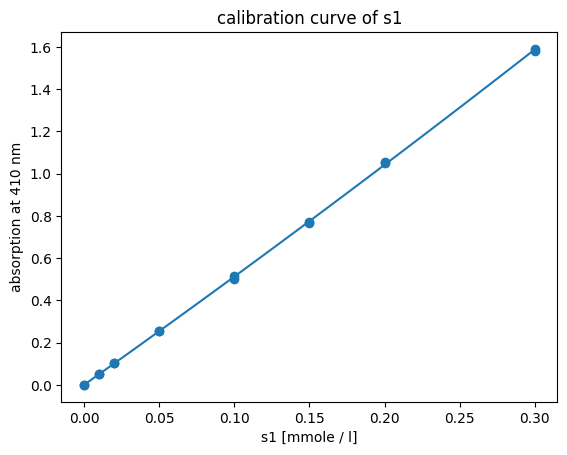

In [2]:
product_standard = StandardCurve.from_excel(
    path="../../data/chymotrypsin_inhibition/pNA-standard.xlsx",
    reactant_id="s1",
    wavelength=410,
    sheet_name="csv", 
    concentration_unit="mmole / l",
    temperature=30,
    temperature_unit="C")
    
product_standard.visualize()

Based on the Akaike information criterion (AIC), the relation between concentration and absorption is best described by a quadratic function. Additionally, the visualization of the fit shows 

### Load experimental data

All experimental data was filled in the EnzymeML Excel template. In the next cell, ```EnzymeMLDocument```s are created by reading the excel template and the measured absorption data is calculated based on the ```StandardCurve``` above.

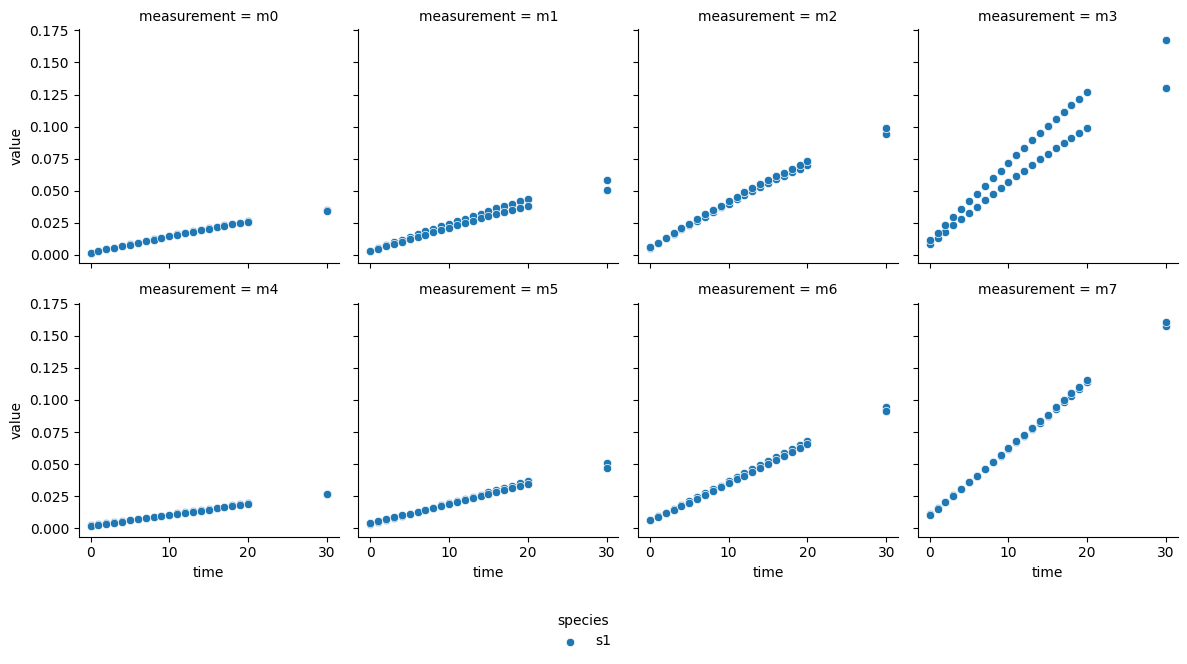

In [3]:
# Load data from 
chymo_HSAwt = pe.EnzymeMLDocument.fromTemplate("../../data/chymotrypsin_inhibition/chymo_HSAwt.xlsx")
chymo_HSAM3 = pe.EnzymeMLDocument.fromTemplate("../../data/chymotrypsin_inhibition/chymo_HSA(M3).xlsx")

# Apply standard curve to 'EnzymeMLDocument's
chymo_HSAwt = product_standard.apply_to_EnzymeML(chymo_HSAwt, "s1")
chymo_HSAM3 = product_standard.apply_to_EnzymeML(chymo_HSAM3, "s1")

# Visualize the measurement data
chymo_HSAwt.visualize()
plt.show()

## Check comparability of the two data sets

Since the experimental data from the HSA wild-type and the HSA(M3) variant originate from independent experiments, the control reactions without the respective inhibitor were compared. Therefore, kinetic parameters were estimated for each dataset, after deleting measurement in which inhibitor was present.

Fit report for irreversible Michaelis Menten model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 168
    # variables        = 2
    chi-square         = 0.00259914
    reduced chi-square = 1.5657e-05
    Akaike info crit   = -1856.85864
    Bayesian info crit = -1850.61071
[[Variables]]
    k_cat:  56.4404600 +/- 2.54941761 (4.52%) (init = 32.216)
    Km:     2.22616597 +/- 0.16207980 (7.28%) (init = 0.32216)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, Km) = 0.984


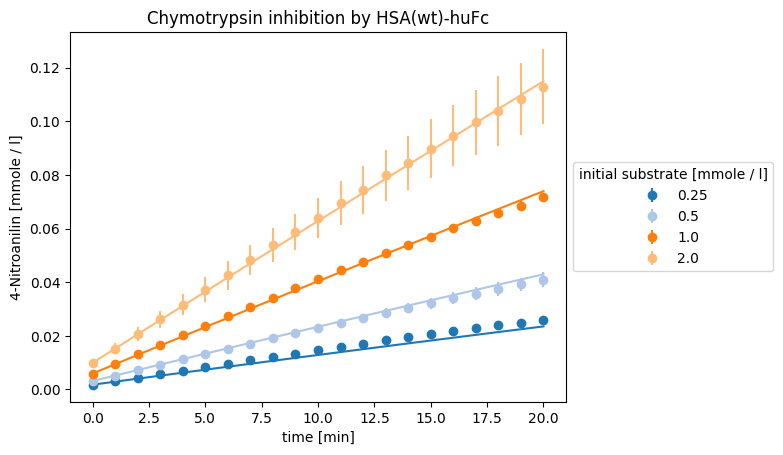

In [14]:
# Create copys of the data sets and delete measuremnts with inhibitor present.
wt_control = copy.deepcopy(chymo_HSAwt)
del wt_control.measurement_dict["m4"]
del wt_control.measurement_dict["m5"]
del wt_control.measurement_dict["m6"]
del wt_control.measurement_dict["m7"]

m3_control = copy.deepcopy(chymo_HSAM3)
del m3_control.measurement_dict["m4"]
del m3_control.measurement_dict["m5"]
del m3_control.measurement_dict["m6"]
del m3_control.measurement_dict["m7"]

# Estimate kinetic parameters of the control reactions of the HSA wild-type data set.
kinetics_wt_control = ParameterEstimator.from_EnzymeML(wt_control, "s1", "product")
kinetics_wt_control.fit_models(stop_time_index=-1, display_output=False)
kinetics_wt_control.visualize()
plt.show()


Fit report for irreversible Michaelis Menten model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 40
    # variables        = 2
    chi-square         = 3.9284e-05
    reduced chi-square = 1.0338e-06
    Akaike info crit   = -549.342639
    Bayesian info crit = -545.964880
[[Variables]]
    k_cat:  48.9963253 +/- 1.09370532 (2.23%) (init = 25.93928)
    Km:     1.97757023 +/- 0.07390215 (3.74%) (init = 0.2593928)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, Km) = 0.981


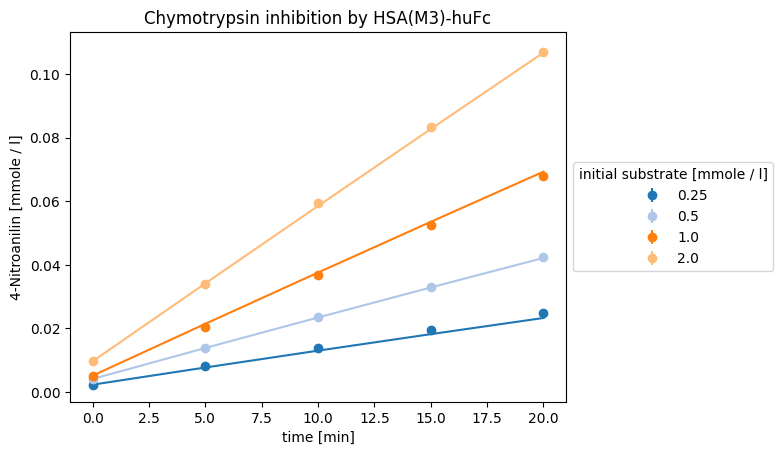

In [15]:
# Estimate kinetic parameters of the control reactions of the HSA(M3) data set.
kinetics_m3_control = ParameterEstimator.from_EnzymeML(m3_control, "s1", "product")
kinetics_m3_control.fit_models(stop_time_index=-1, display_output=False)
kinetics_m3_control.visualize()

Statistical analysis between the parameters $k_{cat}$ and $K_{m}$ high correlation above 0.98. This indicates, that the highest applied substrate concentration of 2 mM is lower than the $K_{m}$ of the enzyme under the given experimental conditions. Therefore, $k_{cat}$ and $K_{m}$ cannot be detemined independently. Instead, the catalytic efficiency $\frac{k_{cat}}{K_{m}}$ is used to assess the comparability of the two data sets.  
In the cell below, 

In [7]:
kinetics_wt_control.result_dict.drop(columns=["kcat [1/min]", "Km [mmole / l]"])

,AIC,kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
irreversible Michaelis Menten,-1857,25.353 +/- 8.57%,-,-
competitive product inhibition,-1856,25.714 +/- 13.37%,0.725 +/- 112.65%,-
uncompetitive product inhibition,-1855,25.272 +/- 13.50%,-,3.175 +/- 428.92%
substrate inhibition,-1855,25.339 +/- 45.93%,-,997.715 +/- 12275.11%
non-competitive product inhibition,-1854,25.787 +/- 13.79%,0.702 +/- 117.81%,179.118 +/- 358.38%


In [8]:
kinetics_m3_control.result_dict.drop(columns=["kcat [1/min]", "Km [mmole / l]"])


,AIC,kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
irreversible Michaelis Menten,-549,24.776 +/- 4.35%,-,-
competitive product inhibition,-549,25.077 +/- 6.47%,0.908 +/- 81.63%,-
uncompetitive product inhibition,-547,24.743 +/- 8.57%,-,7.445 +/- 631.41%
non-competitive product inhibition,-547,25.073 +/- 8.69%,0.914 +/- 83.56%,121.556 +/- 2156.85%
substrate inhibition,-545,24.623 +/- 6.36%,-,87.549 +/- 121.66%


## Parameter estimation for $K_{i}$

Fit report for competitive inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 192
    # variables        = 3
    chi-square         = 2.3179e-04
    reduced chi-square = 1.2264e-06
    Akaike info crit   = -2610.42088
    Bayesian info crit = -2600.64839
[[Variables]]
    k_cat:  58.4194734 +/- 3.07343419 (5.26%) (init = 32.216)
    Km:     2.40964189 +/- 0.16685944 (6.92%) (init = 0.32216)
    K_ic:   0.16660734 +/- 0.01334184 (8.01%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, Km)   = 0.994
    C(Km, K_ic)    = 0.226
    C(k_cat, K_ic) = 0.155


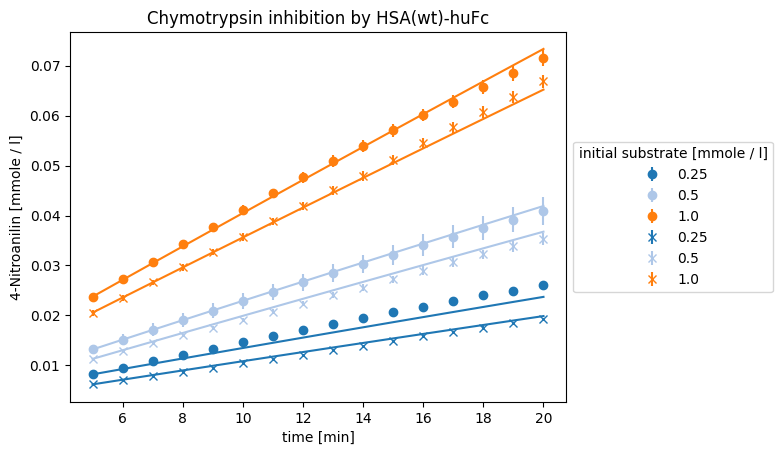

In [9]:
kinetics_HSAwt = ParameterEstimator.from_EnzymeML(chymo_HSAwt, reactant_id="s1", inhibitor_id="s2", measured_species="product")
kinetics_HSAwt.fit_models(initial_substrate_concs=[0.25, 0.5, 1], stop_time_index=-1, start_time_index=5, display_output=False)
kinetics_HSAwt.visualize()

Fit report for competitive inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 48
    # variables        = 3
    chi-square         = 4.5653e-05
    reduced chi-square = 1.0145e-06
    Akaike info crit   = -659.551002
    Bayesian info crit = -653.937399
[[Variables]]
    k_cat:  51.5408838 +/- 4.86492036 (9.44%) (init = 25.93928)
    Km:     2.08717809 +/- 0.26800246 (12.84%) (init = 0.2593928)
    K_ic:   0.04033446 +/- 0.00255307 (6.33%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, Km)   = 0.994
    C(Km, K_ic)    = 0.529
    C(k_cat, K_ic) = 0.476


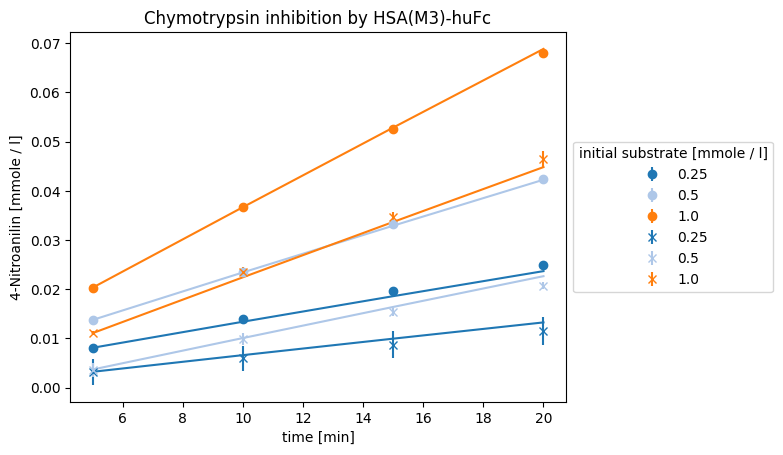

In [10]:
kinetics_HSAM3 = ParameterEstimator.from_EnzymeML(chymo_HSAM3, reactant_id="s1", inhibitor_id="s3", measured_species="product")
kinetics_HSAM3.fit_models(initial_substrate_concs=[0.25, 0.5, 1], stop_time_index=-1, start_time_index=1, display_output=False)
kinetics_HSAM3.visualize()

In [11]:
kinetics_HSAwt.result_dict.drop(columns=["kcat [1/min]", "Km [mmole / l]"])


,AIC,kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
competitive inhibition,-2610,24.244 +/- 8.70%,0.167 +/- 8.01%,-
non-competitive inhibition,-2608,24.278 +/- 8.78%,0.166 +/- 8.89%,179.251 +/- 144.95%
partially competitive inhibition,-2608,24.259 +/- 8.71%,0.038 +/- 4523.76%,0.057 +/- 5860.79%
uncompetitive inhibition,-2542,22.413 +/- 12.40%,-,0.060 +/- 15.71%
irreversible Michaelis Menten,-2482,22.236 +/- 12.79%,-,-


In [12]:
kinetics_HSAM3.result_dict.drop(columns=["kcat [1/min]", "Km [mmole / l]"])

,AIC,kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
competitive inhibition,-660,24.694 +/- 15.94%,0.040 +/- 6.33%,-
non-competitive inhibition,-658,24.764 +/- 15.67%,0.040 +/- 7.49%,92.539 +/- 829.16%
uncompetitive inhibition,-593,20.056 +/- 60.17%,-,0.008 +/- 42.94%
irreversible Michaelis Menten,-537,18.545 +/- 74.56%,-,-
partially competitive inhibition,-533,18.527 +/- 77.78%,873.323 +/- 18344.27%,321.232 +/- 44875.43%


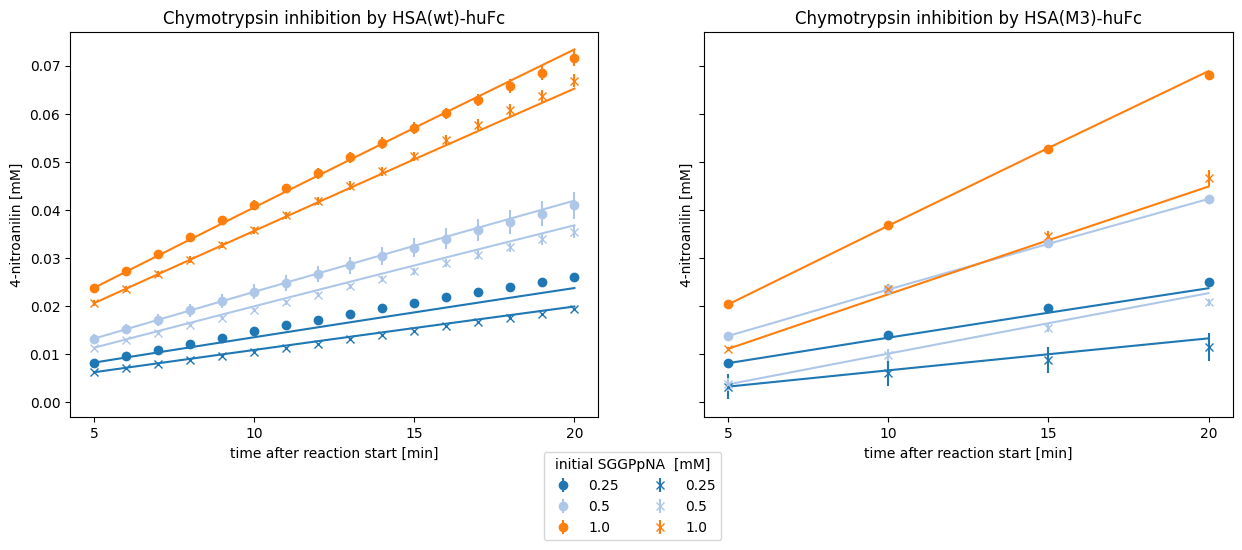

In [13]:
fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True, sharex=True)
for e, (doc, ax) in enumerate(zip([kinetics_HSAwt ,kinetics_HSAM3], axes.flatten())):
    doc.visualize(ax=ax)
    ax.set_ylabel("4-nitroanilin [mM]")
    ax.set_xlabel("time after reaction start [min]")
    ax.set_xticks([5, 10, 15, 20])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc="lower center", ncol=2, title="initial SGGPpNA  [mM]", bbox_to_anchor=(0.5,-0.15))
plt.show()